In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from scipy import optimize as opt
import math as m
from numpy.linalg import eig, inv, svd
from mpl_toolkits.mplot3d import Axes3D

In [63]:
data_S62 = np.genfromtxt("PosData_S62.txt", unpack=True, skip_header=1)
data_S62 = [data_S62[0], data_S62[1]*10**-3, data_S62[3]*10**-3, data_S62[2]*10**-3, data_S62[4]*10**-3]
x_S62 = data_S62[1]
y_S62 = data_S62[2]

data_S2 = np.genfromtxt("PosData_S2.txt", unpack=True, skip_header=1)
x_S2 = data_S2[1]
y_S2 = data_S2[2]

data_S38 = np.genfromtxt("PosData_S38.txt", unpack=True, skip_header=1)
x_S38 = data_S38[1]
y_S38 = data_S38[2]

data_S55 = np.genfromtxt("PosData_S55.txt", unpack=True, skip_header=1)
x_S55 = data_S55[1]
y_S55 = data_S55[2]

In [64]:
def r_theta_data(data, x_F = 0, y_F = 0):
    r = []
    theta = []
    
    for i in range(len(data[1])):
        r.append(np.sqrt((data[1][i] - x_F)**2+(data[2][i] - y_F)**2))
        if data[1][i] - x_F == 0:
            theta.append(1/2*np.pi)
        elif data[1][i] - x_F > 0:
            theta.append(np.arctan((data[2][i] - y_F)/(data[1][i] - x_F)))
        elif data[1][i] - x_F < 0:
            theta.append(np.pi + np.arctan((data[2][i] - y_F)/(data[1][i] - x_F)))
        else: 
            theta.append('NA')
            
    return r, theta

In [65]:
def my_f_ellipse(a, e, phi, xf, yf, theta):
    r = a*(1-e**2)/(1-e*np.cos(theta - phi))
    x = r*np.cos(theta) + xf
    y = r*np.sin(theta) + yf
    return r, [x,y]

In [66]:
def __fit_ellipse(x, y):
    x, y = x[:, np.newaxis], y[:, np.newaxis]
    D = np.hstack(( x*x, x*y, y*y, x, y, np.ones_like(x) ))
    S, C = np.dot(D.T, D), np.zeros([6,6])
    C[0,2], C[2,0], C[1,1] = 2,2,-1
    U, s, V = svd(np.dot(inv(S), C))
    a = U[:,0]
    
    return a

def ellipse_center(a):
    b, c, d, f, g, a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    
    num = b*b-a*c
    x0 = (c*d-b*f)/num
    y0 = (a*f-b*d)/num
    
    return np.array([x0, y0])

def ellipse_axis_length(a):
    b, c, d, f, g, a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    
    up = 2*(a*f*f + c*d*d + g*b*b - 2*b*d*f - a*c*g)
    down1 = (b*b-a*c) * ((c-a)*np.sqrt(1+4*b*b/( (a-c)*(a-c) )) -(a+c) )
    down2 = (b*b-a*c) * ((a-c)*np.sqrt(1+4*b*b/( (a-c)*(a-c) )) -(a+c) )
    
    res1 = np.sqrt(up/down1)
    res2 = np.sqrt(up/down2)    
    
    return np.array([res1, res2])

def ellipse_angle_of_rotation(a):
    b, c, d, f, g, a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return m.atan2(2*b,(a-c))/2
    
def fit_ellipse(x,y):
    a = __fit_ellipse(x,y)

    center = ellipse_center(a)
    phi = ellipse_angle_of_rotation(a)
    M,m = ellipse_axis_length(a)

    if m > M:
        M,m = m,M
        
    phi -= 2*np.pi*int(phi/(2*np.pi))
    return [M, m, center[0], center[1], phi]    

In [82]:
def ellipse_plot_method2_test(data, phi, plot='true'):
    arc = 2
    R = np.arange(0,arc*np.pi, 0.01)

    x = data[1]
    y = data[2]
    
    M, m, c_x, c_y, angle = fit_ellipse(x,y)
    
    xx = c_x + M*np.cos(R)*np.cos(phi) - m*np.sin(R)*np.sin(phi)
    yy = c_y + M*np.cos(R)*np.sin(phi) + m*np.sin(R)*np.cos(phi)
    
    
#    plt.plot(x,y, '*', color='blue')
    if plot == 'true':
        plt.plot(xx,yy, color='red')
    
    return xx, yy

def ellipse_fit_2(data):
    x = data[1]
    y = data[2]
    
    fit = fit_ellipse(x,y)
    
    a = fit[0]
    e = np.sqrt(1 - (fit[1]/fit[0])**2)
    phi = fit[-1]
    c_x = fit[2]
    c_y = fit[3]
    return a, e, phi, c_x, c_y
    

In [83]:
fit = ellipse_fit_2(data_S2)
a = fit[0]
e = fit[1]
phi = fit[2]
c_x = fit[3]
c_y = fit[4]
b = a*np.sqrt(1-e**2)
    
angle = m.atan2( (c_y), (c_x))
focal_points_x = [c_x-a*e*np.cos(angle),c_x+a*e*np.cos(angle)]
focal_points_y = [c_y-a*e*np.sin(angle), c_y+a*e*np.sin(angle)]

xx = ellipse_plot_method2_test(data_S2, angle, plot='no')[0]
yy = ellipse_plot_method2_test(data_S2, angle, plot='no')[1]

test_data = [[0], xx, yy]
r, theta = r_theta_data(test_data)

focal_data = [[0], focal_points_x, focal_points_y]
r_f, theta_f = r_theta_data(focal_data)

X = []
Y = []
for i in range(len(r)):
    X.append(r[i]*np.cos(theta[i] - angle + 0.5*np.pi))
    Y.append(r[i]*np.sin(theta[i] - angle + 0.5*np.pi))

X_f = []
Y_f = []
for i in range(len(r_f)):
    X_f.append(r_f[i]*np.cos(theta_f[i] - angle + 0.5*np.pi))
    Y_f.append(r_f[i]*np.sin(theta_f[i] - angle + 0.5*np.pi))

C_x = 0
C_y = min(Y_f) + a*e

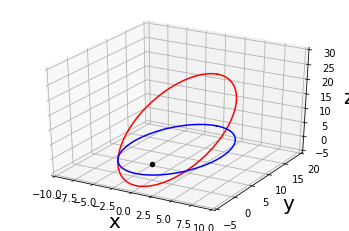

In [84]:
inc = np.radians(45)

t = np.linspace(0,2*np.pi, 720)
r = my_f_ellipse(a,e,np.radians(0),0,0,t)[0]
x = r*np.cos(t)
y = r*np.sin(t)    

X = [x*100 for x in X]
Y = [y*100 for y in Y]
Z = np.array([Y[i]*np.tan(inc) for i in range(len(X))])

centerx, centery, centerz = C_x, C_y, C_y*np.tan(inc)

endsx = [0,0]
endsy = [centery+a, centery-a]
endsz = [centerz+a*np.tan(inc), centerz-a*np.tan(inc)]

focus_dist = np.sqrt( (a/np.cos(inc))**2 - (b)**2 )

focusx = [0,0]
focusy = [centery + focus_dist*np.cos(inc), centery - focus_dist*np.cos(inc)]
focusz = [centerz + focus_dist*np.sin(inc), centerz - focus_dist*np.sin(inc)]


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.plot(X,Y, Z, c='red')
ax.plot(X,Y, c='blue')
ax.scatter(0,0,0, 'o', c='black')
#ax.scatter(centerx, centery, centerz, 'o', color='blue')
#ax.scatter(endsx, endsy, endsz, 'o', color='red')
#ax.scatter(focusx, focusy, focusz, 'o', color='green')
ax.set_xlabel('x', fontsize = 20)
ax.set_ylabel('y', fontsize = 20)
ax.set_zlabel('z', fontsize = 20)
ax.set_xlim3d(-10, 10)
ax.set_ylim3d(-5,20)
ax.set_zlim3d(-5,30)
plt.show()

In [60]:
%matplotlib qt

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from scipy import optimize as opt
import math as m
from numpy.linalg import eig, inv, svd
from mpl_toolkits.mplot3d import Axes3D


data_S62 = np.genfromtxt("PosData_S62.txt", unpack=True, skip_header=1)
data_S62 = [data_S62[0], data_S62[1]*10**-3, data_S62[3]*10**-3, data_S62[2]*10**-3, data_S62[4]*10**-3]
x_S62 = data_S62[1]
y_S62 = data_S62[2]

data_S2 = np.genfromtxt("PosData_S2.txt", unpack=True, skip_header=1)
x_S2 = data_S2[1]
y_S2 = data_S2[2]

data_S38 = np.genfromtxt("PosData_S38.txt", unpack=True, skip_header=1)
x_S38 = data_S38[1]
y_S38 = data_S38[2]

data_S55 = np.genfromtxt("PosData_S55.txt", unpack=True, skip_header=1)
x_S55 = data_S55[1]
y_S55 = data_S55[2]

def r_theta_data(data, x_F = 0, y_F = 0):
    r = []
    theta = []
    
    for i in range(len(data[1])):
        r.append(np.sqrt((data[1][i] - x_F)**2+(data[2][i] - y_F)**2))
        if data[1][i] - x_F == 0:
            theta.append(1/2*np.pi)
        elif data[1][i] - x_F > 0:
            theta.append(np.arctan((data[2][i] - y_F)/(data[1][i] - x_F)))
        elif data[1][i] - x_F < 0:
            theta.append(np.pi + np.arctan((data[2][i] - y_F)/(data[1][i] - x_F)))
        else: 
            theta.append('NA')
            
    return r, theta








def my_f_ellipse(a, e, phi, xf, yf, theta):
    r = a*(1-e**2)/(1-e*np.cos(theta - phi))
    x = r*np.cos(theta) + xf
    y = r*np.sin(theta) + yf
    return r, [x,y]

def residual2(a, e, phi, xf, yf, theta, r):
    return (r - my_f_ellipse(a,e,phi,xf,yf,theta)[0])**2
    

def my_ultimat_fit(data):
    
    def sqr_sum_f_ellipse(parameters):
        a, e, phi, xf, yf = parameters
        r, theta = r_theta_data(data, x_F = xf, y_F=yf)
        
        residuals = []
        
        for i in range(len(r)):
            R = residual2(a,e,phi,xf,yf,theta[i],r[i])
#            residuals.append(R/(data[3][i]+data[4][i]))
            residuals.append(R)
 
            
        return sum(residuals)
    
    r, theta = r_theta_data(data)
    furthest_point = r.index(max(r))
    fp = furthest_point
        
    phi_guess = theta[fp]
    a_max = max(r)
    a_min = 0.5*max(r)
        
    center_area_x = (min(0,min(data[1]))*0.5, max(0,max(data[1]))*0.5)
    center_area_y = (min(0,min(data[2]))*0.5, max(0,max(data[2]))*0.5)

    guess_init = [0.1, 0.8, 0.5*np.pi, 0, 0]
#    guess_init = [a_min+0.01, 0.95, phi_guess, 0, 0]
#    guess_init = [0.1, 0.8, 0.5*np.pi, 0, 0]
#    guess_init = [0.125, 0.88, 0.5*np.pi, -0.0151, 0.0686]
#    guess_init = ellipse_fit_2(data)
    
    bnds = ((0,0.5), (0.5,0.99), (0,2*np.pi), (-0.4,0.2), (-0.2,0.2))
#    bnds = ((a_min,a_max), (0.7,0.99), (phi_guess-0.125*np.pi,phi_guess+0.125*np.pi), center_area_x, center_area_y)
#    bnds = ((a_min+0.01,a_min+0.02), (0.95,0.99), (phi_guess-0.00001, phi_guess+0.00001), (-0.01,0.01), (-0.01,0.01))
    
    result = opt.minimize(sqr_sum_f_ellipse, guess_init, method='L-BFGS-B', bounds=bnds)    
    
    X1 = []
    Y1 = []
        
    a, e, phi, xf, yf = result.x
        
    for i in np.linspace(0, 2*np.pi, 720):
        theta = i 
        r = my_f_ellipse(a,e,phi,xf,yf,theta)[0]
        x = r*np.cos(i) + xf
        y = r*np.sin(i) + yf
            
        X1.append(x)
        Y1.append(y)
    
    plt.figure()
#    plt.plot(xf, yf, 'x')
#    plt.plot(xf+2*a*e*np.cos(phi), yf+2*a*e*np.sin(phi), 'x')
    plt.plot(X1, Y1, color='orange')
#    plt.plot(data[1], data[2], '*')
#    plt.plot(0,0,'o', color='black')
    
    return result.x, X1, Y1





# The parametrized function to be plotted
#def f(t, amplitude, frequency):
#    return amplitude * np.sin(2 * np.pi * frequency * t)

def f(t, a, e, omega, OMEGA, inc):
    A = (np.cos(omega)*np.cos(OMEGA) - np.sin(omega)*np.sin(OMEGA)*np.cos(inc)) #*a
    C = (np.cos(omega)*np.sin(OMEGA) + np.sin(omega)*np.cos(OMEGA)*np.cos(inc)) #*a
    B = (-np.sin(omega)*np.cos(OMEGA) - np.cos(omega)*np.sin(OMEGA)*np.cos(inc)) #*a
    D = (-np.sin(omega)*np.sin(OMEGA) + np.cos(omega)*np.cos(OMEGA)*np.cos(inc)) #*a
    
    r = my_f_ellipse(a,e,np.radians(0),0,0,t)[0]
    x = r*np.cos(t)
    y = r*np.sin(t)    
    
    X = A*x+B*y
    Y = C*x+D*y
    return X, Y
#    return x,y
#    return A*my_f_ellipse(a,e,0,0,0,t)*np.cos(t)+F*my_f_ellipse(a,e,0,0,0,t)*np.sin(t), B*my_f_ellipse(a,e,0,0,0,t)*np.cos(t)+G*my_f_ellipse(a,e,0,0,0,t)*np.sin(t)

t = np.linspace(0, 2*np.pi, 720)
#t = np.linspace(0, 2*np.pi, 5)

# Define initial parameters
init_a = 0.1254
init_e = 0.88466
init_omega = 2.06
#init_omega = np.radians(66.13)
init_OMEGA = np.radians(227.85)
init_inc = np.radians(133.818)

#init_a = 0.11
#init_e = 0.67
#init_omega = 3.74
#init_OMEGA = 2.25
#init_inc = 2.49

#plt.plot(f(t,init_a,init_e,init_omega,init_OMEGA,init_inc)[0], f(t,init_a,init_e,init_omega,init_OMEGA,init_inc)[1])

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = plt.plot(f(t,init_a,init_e,init_omega,init_OMEGA,init_inc)[0], f(t,init_a,init_e,init_omega,init_OMEGA,init_inc)[1])
plt.plot(data_S2[1], data_S2[2],'*')
plt.plot(0,0,'o',c='black')
#plt.xlim([0.1,-0.1])
#plt.ylim([-0.05,0.2])
#ax.set_xlabel('Dec ["]')
#plt.xlim([0.5,-0.5])
#plt.ylim([-0.5,0.5])

axcolor = 'lightgoldenrodyellow'
ax.margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
a_slider = Slider(
    ax=axfreq,
    label='a',
    valmin=0,
    valmax=0.3,
    valinit=init_a,
)

axfreq = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
omega_slider = Slider(
    ax=axfreq,
    label='Om',
    valmin=0,
    valmax=2*np.pi,
    valinit=init_omega,
)


# Make a vertically oriented slider to control the amplitude
axamp = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
e_slider = Slider(
    ax=axamp,
    label="e",
    valmin=0,
    valmax=1,
    valinit=init_e,
    orientation="vertical"
)


axamp = plt.axes([0.05, 0.25, 0.0225, 0.63], facecolor=axcolor)
OMEGA_slider = Slider(
    ax=axamp,
    label="OM",
    valmin=0,
    valmax=2*np.pi,
    valinit=init_OMEGA,
    orientation="vertical"
)

axamp = plt.axes([0.95, 0.25, 0.0225, 0.63], facecolor=axcolor)
inc_slider = Slider(
    ax=axamp,
    label="Inc",
    valmin=0,
    valmax=2*np.pi,
    valinit=init_inc,
    orientation="vertical"
)



# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, a_slider.val, e_slider.val, omega_slider.val, OMEGA_slider.val, inc_slider.val)[1])
    line.set_xdata(f(t, a_slider.val, e_slider.val, omega_slider.val, OMEGA_slider.val, inc_slider.val)[0])
    fig.canvas.draw_idle()


# register the update function with each slider
a_slider.on_changed(update)
e_slider.on_changed(update)
omega_slider.on_changed(update)
OMEGA_slider.on_changed(update)
inc_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    a_slider.reset()
    e_slider.reset()
    omega_slider.reset()
    OMEGA_slider.reset()
    inc_slider.reset()
button.on_clicked(reset)


plt.show()









def improve_data(data, error_limit=0, multiplyer=0.8):
    if error_limit==0:
        error_limit = (max(data[3])+max(data[4]))*multiplyer
        
    index_list = []
    for i in range(len(data[3])):
        if (data[3][i] + data[4][i]) < error_limit:
            index_list.append(i)
    
    a = []
    b = []
    c = []
    d = []
    e = []

    for i in index_list:
        a.append(data[0][i])
        b.append(data[1][i])
        c.append(data[2][i])
        d.append(data[3][i])
        e.append(data[4][i])
    
    data_improved = [a,b,c,d,e]
    return data_improved















#def the_mega_function2(data,n):
#    t = np.linspace(0,2*np.pi, 10)
#    xdata = data[1]
#    ydata = data[2]
#    avg_dist_list = []
#    a_list = []
#    e_list = []
#    omega_list = []
#    OMEGA_list = []
#    inc_list = []
    
#    nummer = 0
    
#    for a in np.linspace(0,0.2,n):
#        for e in np.linspace(0.1,0.99,n):
#            for omega in np.linspace(0,2*np.pi,n):
#                for OMEGA in np.linspace(0,2*np.pi,n):
#                    for inc in np.linspace(0,2*np.pi,n):
#                        a_list.append(a)
#                        e_list.append(e)
#                        omega_list.append(omega)
#                        OMEGA_list.append(OMEGA)
#                        inc_list.append(inc)
#                        
#                        nummer = nummer + 1
#                        print("We are now at:", nummer, "out of:", n**5, " ", round(nummer/n**5 * 100,2),"percent done.")
#                        
#                        X = f(t, a, e, omega, OMEGA, inc)[0]
#                        Y = f(t, a, e, omega, OMEGA, inc)[1]
#                        
#                        dist_all_points = []
#                        for i in range(len(xdata)):
#                            min_dist_to_point = 10
#                            for j in range(len(X)):
#                                d = np.sqrt( (xdata[i] - X[j])**2 + (ydata[i] - Y[j])**2 )/(np.sqrt(data[3][i]**2+data[4][i]**2))
#                                if d < min_dist_to_point:
#                                    min_dist_to_point = d
#                            dist_all_points.append(min_dist_to_point)
#                        avg_dist = sum(dist_all_points)/len(dist_all_points)
#                        avg_dist_list.append(avg_dist)
#    
#    index = avg_dist_list.index(min(avg_dist_list))
#    return a_list[index], e_list[index], omega_list[index], OMEGA_list[index], inc_list[index], min(avg_dist_list)

    



Y = 0
X = -0.025

init_omega = 0.98

A = (np.cos(init_omega)*np.cos(init_OMEGA) - np.sin(init_omega)*np.sin(init_OMEGA)*np.cos(init_inc)) #*a
C = (np.cos(init_omega)*np.sin(init_OMEGA) + np.sin(init_omega)*np.cos(init_OMEGA)*np.cos(init_inc)) #*a
B = (-np.sin(init_omega)*np.cos(init_OMEGA) - np.cos(init_omega)*np.sin(init_OMEGA)*np.cos(init_inc)) #*a
D = (-np.sin(init_omega)*np.sin(init_OMEGA) + np.cos(init_omega)*np.cos(init_OMEGA)*np.cos(init_inc)) #*a

y_thingy = (Y/C - X/A)/(D/C - B/A)

ratio_thingy = A*y_thingy/(X-B*y_thingy)

np.arctan(ratio_thingy)




0.030973627875857102

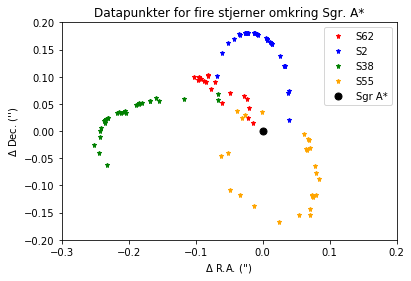

In [81]:
plt.plot(data_S62[1], data_S62[2], '*', color='red', markersize=5)
plt.plot(data_S2[1], data_S2[2], '*', color='blue', markersize=5)
plt.plot(data_S38[1], data_S38[2], '*', color='green', markersize=5)
plt.plot(data_S55[1], data_S55[2], '*', color='orange', markersize=5)
plt.plot(0,0, 'o', color='black', markersize=7)

plt.title("Datapunkter for fire stjerner omkring Sgr. A*")
plt.xlim([-0.3, 0.2])
plt.ylim([-0.2,0.2])
plt.xlabel("$\Delta$ R.A. ('""')")
plt.ylabel("$\Delta$ Dec. ('""')")
plt.legend(["S62", "S2", "S38", "S55", "Sgr A*"])

In [86]:
%matplotlib qt

In [ ]:
%matplotlib inline